In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def import_matlab_data(filename):
    """Taking a Matlab file of Arbin data from the CALCE database and imports it into a host of different NumPy arrays"""
    
    import hdf5storage
    import numpy as np
    import pandas as pd
    
    #Importing the file as a HDF5 dataframe, stored in the form of a dictionary.  
    df = hdf5storage.loadmat(filename)
    return df


def load_matlab_data(filename):
    """Takes a Matlab file of Arbin data from the CALCE database, imports it, and parses it into a dictionary that most
    closely resembles the cell array structure in Matlab"""
    
    import hdf5storage
    import numpy as np
    import pandas as pd
    
    #Calling the imported dataframe. 
    df = import_matlab_data(filename)
    keys = df.keys()
 
    #Creating an empty dictionary. 
    data_dict = {}
    count = 2
    
    # For assigning the correct dictionary keys for the for loops later. 
    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
    
    for idx in range(1, len(df[data])):
        operation = str(df[data][idx][0][0][0])
        start_date = str(df[data][idx][1][0][0])

        #name = filename.split(".")
        if df[data][idx][2].shape == (0,0):
            pass
        
        else:
            host_df = pd.DataFrame()

            host_df['time'] = df['#subsystem#'][0][0][0][count][0][0].flatten()
            host_df['datetime'] = df['#subsystem#'][0][0][0][count][0][1].flatten()
            host_df['step'] = df['#subsystem#'][0][0][0][count][0][2].flatten()
            host_df['cycle'] = df['#subsystem#'][0][0][0][count][0][3].flatten()
            host_df['current_amp'] = df['#subsystem#'][0][0][0][count][0][4].flatten()
            host_df['voltage'] = df['#subsystem#'][0][0][0][count][0][5].flatten()
            host_df['charge_ah'] = df['#subsystem#'][0][0][0][count][0][6].flatten()
            host_df['discharge_ah'] = df['#subsystem#'][0][0][0][count][0][7].flatten()

            data_dict[operation + ' ' + start_date] = host_df

            count = count + 7

            if count > len(df['#subsystem#'][0][0][0]):
                break
    
    return data_dict

In [67]:
def initialize_datasets(filename):
    """this function takes in a dataframe generated from the Matlab files. For the partial discharge curves and 
    initializes the data so that cycle 1 corresponds to the beginning of the partial cycling experiments, and
    not to full charge/discharge data."""
    # Initializing each parameter with the first datasets

    # Will need to do a separate for loop to see if where we initalize the code is correct.
    # Coordinate the count and the index so that if the data series in the count is < 3000, pass and
    # move onto the next index. If it finally gets initialized, then do the for loop to continue in adding
    # all the other mumbo jumbo
    
    df = import_matlab_data(filename)
    keys = df.keys()

    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
    
    count = 2
    for idx in range(1, len(df[data])):
        time_sum = df['#subsystem#'][0][0][0][count][0][0].flatten()
        if len(time_sum) < 3500:
            count = count + 7
        else:
            datetime_sum = df['#subsystem#'][0][0][0][count][0][1].flatten()
            step_sum = df['#subsystem#'][0][0][0][count][0][2].flatten()
            cycle_sum = df['#subsystem#'][0][0][0][count][0][3].flatten()
            current_sum = df['#subsystem#'][0][0][0][count][0][4].flatten()
            voltage_sum = df['#subsystem#'][0][0][0][count][0][5].flatten()
            charge_ah_sum = df['#subsystem#'][0][0][0][count][0][6].flatten()
            discharge_ah_sum = df['#subsystem#'][0][0][0][count][0][7].flatten()
            count = count + 7
            break
    
    return count, idx, time_sum, datetime_sum, step_sum, cycle_sum, current_sum, voltage_sum, charge_ah_sum, discharge_ah_sum

In [77]:
#This is the function we use, not the load_matlab one. 

def single_pd_matlab_data(filename):
    
    df = import_matlab_data(filename)
    keys = df.keys()

    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
            
    count, idx, time_sum, datetime_sum, step_sum, cycle_sum, current_sum, voltage_sum, charge_ah_sum, discharge_ah_sum = initialize_datasets(filename)
    start_ind = idx + 1
    #time_sum = df['#subsystem#'][0][0][0][2][0][0].flatten()
    #datetime_sum = df['#subsystem#'][0][0][0][2][0][1].flatten()
    #step_sum = df['#subsystem#'][0][0][0][2][0][2].flatten()
    #cycle_sum = df['#subsystem#'][0][0][0][2][0][3].flatten()
    #current_sum = df['#subsystem#'][0][0][0][2][0][4].flatten()
    #voltage_sum = df['#subsystem#'][0][0][0][2][0][5].flatten()
    #charge_ah_sum = df['#subsystem#'][0][0][0][2][0][6].flatten()
    #discharge_ah_sum = df['#subsystem#'][0][0][0][2][0][7].flatten()
    #count = 9

    for idx in range(int(start_ind), len(df[data])):
        length_test = (df['#subsystem#'][0][0][0][count][0][0].flatten())
        #To access the number of cycles in each dataset. 
        
        #For missing data. 
        if df[data][idx][2].shape == (0,0):
            name = df[data][idx][0][0][0]
            name = name.split(' ')
            number = float(name[0])
            cycle_sum = np.append(cycle_sum, (cycle_sum[-1] + number))
        elif len(length_test) < 3500:
            count = count + 7
        else:
            time_idx = (df['#subsystem#'][0][0][0][count][0][0].flatten()) + time_sum[-1]
            time_sum = np.concatenate((time_sum, time_idx), axis = 0)

            datetime_idx = df['#subsystem#'][0][0][0][count][0][1].flatten()
            datetime_sum = np.concatenate((datetime_sum, datetime_idx), axis = 0)

            step_idx = df['#subsystem#'][0][0][0][count][0][2].flatten()
            step_sum = np.concatenate((step_sum, step_idx), axis = 0)

            if len(cycle_sum) > len(current_sum):
                diff = len(cycle_sum) - len(current_sum)
                cycle_prior = cycle_sum[-1]
                for i in range(0,diff):
                    cycle_sum = np.delete(cycle_sum, -1)
                cycle_idx = (df['#subsystem#'][0][0][0][count][0][3].flatten()) + cycle_prior
                cycle_test = (df['#subsystem#'][0][0][0][count][0][3].flatten())
                cycle_sum = np.concatenate((cycle_sum, cycle_idx), axis = 0)
            else:
                cycle_prior = cycle_sum[-1]
                cycle_idx = (df['#subsystem#'][0][0][0][count][0][3].flatten()) + cycle_prior
                cycle_test = (df['#subsystem#'][0][0][0][count][0][3].flatten())
                cycle_sum = np.concatenate((cycle_sum, cycle_idx), axis = 0)

            current_idx = df['#subsystem#'][0][0][0][count][0][4].flatten()
            current_sum = np.concatenate((current_sum, current_idx), axis = 0)

            voltage_idx = df['#subsystem#'][0][0][0][count][0][5].flatten()
            voltage_sum = np.concatenate((voltage_sum, voltage_idx), axis = 0)
            
            #if voltage_sum.any(abs(voltage_sum - np.mean(voltage_sum)) > 2 * np.std(voltage_sum)):
            #    pass

            charge_ah_idx = df['#subsystem#'][0][0][0][count][0][6].flatten()
            charge_ah_sum = np.concatenate((charge_ah_sum, charge_ah_idx), axis = 0)

            discharge_ah_idx = df['#subsystem#'][0][0][0][count][0][7].flatten()
            discharge_ah_sum = np.concatenate((discharge_ah_sum, discharge_ah_idx), axis = 0)

            count = count + 7

            if count > (len(df['#subsystem#'][0][0][0])-7):
                break


    host_df = pd.DataFrame()

    host_df['time'] = time_sum
    host_df['datetime'] = datetime_sum
    host_df['step'] = step_sum
    host_df['cycle'] = cycle_sum
    host_df['current_amp'] = current_sum
    host_df['voltage'] = voltage_sum
    host_df['charge_ah'] = charge_ah_sum
    host_df['discharge_ah'] = discharge_ah_sum
    
    return host_df


In [60]:
def sort_by_cycle(filename):
    
    df = single_pd_matlab_data(filename)
    
    cycle_dict = {}
    cycle_list = df['cycle'].unique()

    for idx in list(cycle_list):
        if idx not in cycle_dict.keys():
            cycle_dict[idx] = df.loc[df['cycle'] == idx]
        else:
            pass
    
    return cycle_dict    
    

In [61]:
def sort_charge_discharge(cycle_dict):
    
    #cycle_dict = sort_by_cycle(filename)
    
    charge_dict = {}
    discharge_dict = {}
    
    for idx in list(cycle_dict.keys()):
        if idx not in charge_dict.keys():
            charge_pred = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
            disc_pred = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
            #charge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
            charge_dict[idx] = charge_pred
            charge_dict[idx] = charge_dict[idx].drop(charge_dict[idx].tail(1).index)
            #discharge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
            discharge_dict[idx] = disc_pred
            discharge_dict[idx] = discharge_dict[idx].drop(discharge_dict[idx].head(1).index)
            #diff = charge_dict[idx].iloc[-1][0] - charge_dict[idx].iloc[-2][0]
            #if diff > 100:
            #    charge_dict[idx].drop(charge_dict[idx].tail(1).index, inplace = True)
            #else:
            #    pass
            #
            #diff2 = discharge_dict[idx].iloc[-1][0] - discharge_dict[idx].iloc[-2][0]
            #if diff2 > 100:
            #    discharge_dict[idx].drop(charge_dict[idx].tail(1).index, inplace = True)
            #else:
            #    pass
        else:
            pass
    print (len(cycle_dict.keys()))
    print (len(charge_dict.keys()))
    print (len(discharge_dict.keys()))
    return charge_dict, discharge_dict

In [237]:
p = sort_by_cycle('converted_PL23.mat')

In [ ]:
#charge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
if charge_pred.shape[0] < 3100:
pass
else:
charge_dict[idx] = charge_pred
charge_dict[idx] = charge_dict[idx].drop(charge_dict[idx].tail(1).index)
#discharge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
if disc_pred.shape[0] < 3100:
pass
else:
discharge_dict[idx] = disc_pred
discharge_dict[idx] = discharge_dict[idx].drop(discharge_dict[idx].head(1).index)

In [238]:
charge, discharge = sort_charge_discharge(p)

1682
1682
1682


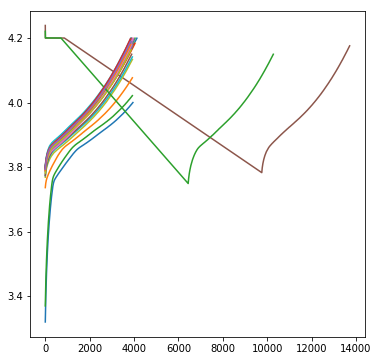

In [239]:
plt.figure(figsize = (6, 6))
for i in range(25, 900, 36):
    if i in charge.keys():
        plt.plot((charge[i]['time']-charge[i]['time'].iloc[0]), charge[i]['voltage'])
    else:
        pass
plt.show()

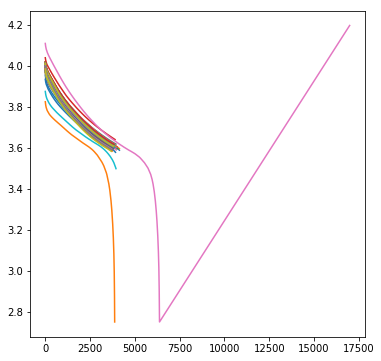

In [240]:
plt.figure(figsize = (6, 6))
for i in range(5, len(discharge.keys()), 41):
    if i in discharge.keys():
        plt.plot((discharge[i]['time']-discharge[i]['time'].iloc[0]), discharge[i]['voltage'])
    else:
        pass
plt.show()

In [90]:
for i in range(5, 900, 12):
    print (i)

5
17
29
41
53
65
77
89
101
113
125
137
149
161
173
185
197
209
221
233
245
257
269
281
293
305
317
329
341
353
365
377
389
401
413
425
437
449
461
473
485
497
509
521
533
545
557
569
581
593
605
617
629
641
653
665
677
689
701
713
725
737
749
761
773
785
797
809
821
833
845
857
869
881
893
